# Tutorial
This is a really short tutorial showing you how PhotochemPy works. To download this notebook, view it on Github using the link in the top-right corner of the screen.

First we will import the PhotochemPy module. 

In [1]:
# Do this one of the following ways!
from PhotochemPy import PhotochemPy # If installed with pip use this!

# If compiled in root directory with compile.sh, uncomment this
# (and comment out the other import command)
# import sys
# sys.path.append("../..")
# from PhotochemPy import PhotochemPy

I'll also import some other standard packages (e.g. numpy).

In [2]:
import numpy as np
from matplotlib import pyplot as plt

## Setting up a problem
PhotochemPy requires a few input files when it is initialized.

- "species.dat": describes the species in the photochemical model, and their boundary conditions.

- "reactions.rx": describes the reactions in the atmosphere and their rates

- "settings.yaml": describes settings (surface gravity, etc.)

- "atmosphere.txt": The initial atmospheric composition, temperature structure, eddy diffusion profile, and aersol parameters.

- "sun_flux.txt": The stellar flux. You can use the [YoungSun](https://github.com/Nicholaswogan/YoungSun) Python package to generate a solar spectrum for Earth at any point in its 4.5 billion year old history.

The best way to start is with one of the templates provided in the `input/templates` directory. Here, I'll use the `Archean2Proterozoic` template.

In [3]:
pc = PhotochemPy('../../input/templates/Archean2Proterozoic/species.dat', \
                 '../../input/templates/Archean2Proterozoic/reactions.rx', \
                 '../../input/templates/Archean2Proterozoic/settings.yaml', \
                 '../../input/templates/Archean2Proterozoic/atmosphere.txt', \
                 '../../input/templates/Archean2Proterozoic/Sun_2.7Ga.txt')

## Integrating to photochemical equilibrium
The problem is now all set up! Now we can do a few different things. The thing that most people will want to do now in integrate the atmosphere forward in time to a state of photochemical equilibrium. We will do that with `pc.integrate()`. 

In [4]:
# here I set the number of steps the integrator will take
converged = pc.integrate(nsteps = 1000, method='Backward_Euler')
print(converged)
converged = pc.integrate(nsteps = 1000, method='CVODE_BDF')
print(converged)

True
True


Two methods are avaliable: `Backward_Euler` and `CVODE_BDF`. `Backward_Euler` (default) is the simple [Backward Euler method](https://en.wikipedia.org/wiki/Backward_Euler_method) for integrating ordinary differential equations (ODEs). `CVODE_BDF` is [Sundial Computing's](https://computing.llnl.gov/projects/sundials/cvode) implementation of the [backward differential formulas](https://en.wikipedia.org/wiki/Backward_differentiation_formula). `CVODE_BDF` is generally more reliable and faster at finding equilibrium atmospheres.

Now we can output the solution. So for example, lets plot the CH$_4$ profile.

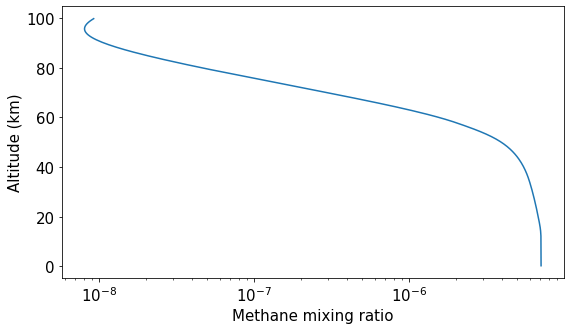

In [6]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[9,5])
CH4 = pc.out_dict()['CH4'].copy()
ax.plot(CH4,pc.out_dict()['alt'])
ax.set_xscale('log')
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Methane mixing ratio')
plt.show()

Currently, the boundary condition for CH$_4$ are set as a fixed surface flux, which we can print below.

In [9]:
ind = pc.ispec.index('CH4') # index of CH4 in the model
print('%.2e'%pc.vars.sgflux[ind])

# quick note: `pc.photo` is a direct contact with all the data stored
# in the compile fortran module. There is a lot of stuff in there...
# to see all the things you can access run this command
# dir(pc.photo)

9.30e+09


Let's change the surface flux then re-integrate the equilibrium.

In [10]:
pc.set_surfflux('CH4',1e11)
converged = pc.integrate(nsteps = 3000)

Now lets compare the atmospheric methane profile to what it was before when the surface flux was lower.

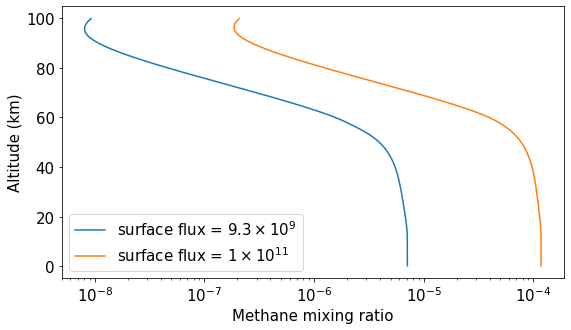

In [11]:
# Plot
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[9,5])
CH4_new = pc.out_dict()['CH4']
ax.plot(CH4,pc.out_dict()['alt'],label=r'surface flux = $9.3 \times 10^9$')
ax.plot(CH4_new,pc.out_dict()['alt'],label=r'surface flux = $1 \times 10^{11}$')
ax.set_xscale('log')
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Methane mixing ratio')
ax.legend()
plt.show()

It took a while to integrate to equilibrium after changing the CH$_4$ surface flux. This is because our initial conditions (the initial atmosphere in atmosphere.txt) are pretty "far away" from the solution. The following command (`pc.out2in()`) changes our initial conditions to the output the the past integration. This will allow much quicker convergence to the equilibrium state.

In [12]:
%time pc.integrate()

pc.out2in() # output to input!

%time pc.integrate()

CPU times: user 2min 25s, sys: 1.17 s, total: 2min 27s
Wall time: 1min 17s
CPU times: user 5.78 s, sys: 43.8 ms, total: 5.82 s
Wall time: 3.02 s


True

## Calculating many surface mixing ratios vs. surface fluxes
Often people want to know how much gas flux at the surface of a planet is required to sustain a particular molecule. Methane or Oxyen, for example, have large surface fluxes on the modern Earth due to life. This bit of code will calculate this relationship for one particular atmosphere.

In [13]:
pc.reset()
CH4_flux = np.logspace(9,11,10)
CH4_mr = []

for flux in CH4_flux:
    pc.set_surfflux('CH4',flux)
    pc.integrate(5000)
    pc.out2in() # really important to do this. It will speed up the computation
    CH4_mr.append(pc.out_dict()['CH4'][0])

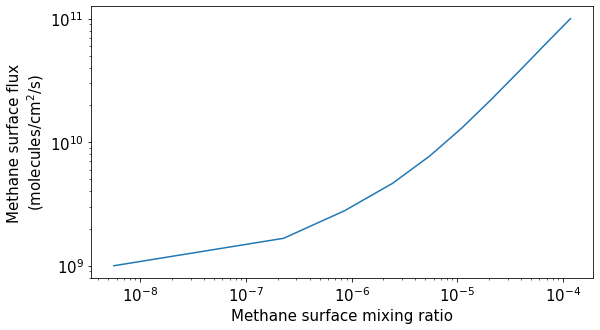

In [14]:
# Plot
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[9,5])

ax.plot(CH4_mr,CH4_flux)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Methane surface flux\n(molecules/cm$^2$/s)')
ax.set_xlabel('Methane surface mixing ratio')

plt.show()

## Evolving atmospheres over time
In the previous section we use PhotochemPy to solve for atmospheric states of photochemical equilibrium. We used `pc.integrate()` to jump from one equilibrium state to another, and we ignored how the atmosphere transitioned between these states. However, now we will solve for the atmospheric evolution with time.

Our example experiment will be modeling the [great oxidation event](https://en.wikipedia.org/wiki/Great_Oxidation_Event) (GOE). We will start with an atmosphere in photochemical equilibirum, then we will increase the O$_2$ surface flux a bit, so that the atmoshpere flips to an oxic state. We will track the atmosphere while all this happens.

In [15]:
pc.reset() # resets everything by reading in original files (e.g. atmosphere.txt)
pc.set_surfflux('O2',4e10) # set surface flux a bit higher

In [17]:
t0 = 0.0 # initial time in seconds
teval = np.logspace(7,14,500) # times to evaluate solution (s)
initial_conditions = pc.vars.usol_init
solution = pc.evolve(t0,initial_conditions,teval,rtol=1e-3,atol=1e-30)

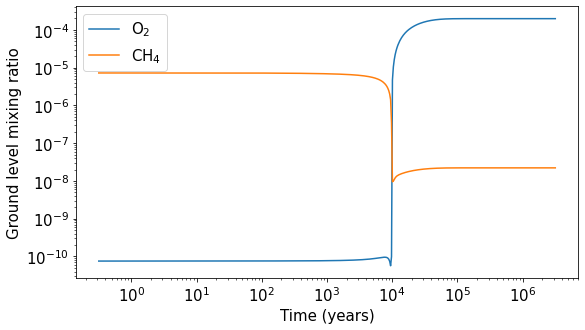

In [18]:
# Plot
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[9,5])

yr = 365*24*60*60
ind = pc.ispec.index('O2')
ax.plot(teval/yr,solution[:,ind,0],label='O$_2$')

ind = pc.ispec.index('CH4')
ax.plot(teval/yr,solution[:,ind,0],label='CH$_4$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Ground level mixing ratio')
ax.set_xlabel('Time (years)')
ax.legend()
plt.show()

`pc.evolve(...)` uses the CVODE BDF method from Sundials Computing. `rtol` and `atol` are relative and absolute tolerances. This is basically the "allowed error" in the integration - CVODE will choose timestep sizes which introduce less error than perscribed by `rtol` and `atol`. The relative tolerance is error allowed relative to a atmospheric mixing ratio. For example, if the O$_2$ mixing ratio is $10^{-9}$, and `rtol = 0.001`, then CVODE will choose a timestep which will introduce no more than $0.001 \times 10^{-9} = 10^{-12}$ error each step. Absolute tolerance is the smallest error that CVODE will care about. This basically means that CVODE will ignore large errors for species that have mixing ratios less than `atol`

I have found that sometimes you have to change `atol` to values between $\sim 10^{-33}$ and $\sim10^{-22}$ to for an integration to proceed at a reasonable speed.